# Segmented regressions with exponential sampling and heteroscedastic noise

In [1]:
%load_ext autoreload
%autoreload 2
from pycewise import *
import random
import matplotlib.pyplot as plt
import numpy

print(__version__)
print(__git_version__)

0.0.6
ee6093db082de75d0dfbcc85241b75e601b5bf2a


In [2]:
min_x = 1
max_x = 1e9
nb_breakpoints = 6
size = 200
numpy.random.seed(27)
#breakpoints = list(sorted(numpy.exp(numpy.random.uniform(numpy.log(min_x), numpy.log(max_x), nb_breakpoints))))
breakpoints = [10**n for n in range(1, 9)]
print(f'Breakpoints: {breakpoints}')
x_list = list(sorted(numpy.exp(numpy.random.uniform(numpy.log(min_x), numpy.log(max_x), size))))
interval_idx = 0
y_list = []
tmp_break = breakpoints + [numpy.inf]
for i, x in enumerate(x_list):
    if x > tmp_break[interval_idx]:
        interval_idx += 1
    assert x <= tmp_break[interval_idx]
    slope = interval_idx*1e-10
    intercept = (interval_idx+1)*10*1e-10
    y_list.append(x*slope + intercept)
dataset = list(zip(x_list, y_list))

Breakpoints: [10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]


In [3]:
sigma = 0.1
noisy_dataset = [(x, y+numpy.random.normal(scale=sigma)*x*1e-10) for x, y in dataset]
x = [t[0] for t in noisy_dataset] 
x = numpy.array(x)
y = [t[1] for t in noisy_dataset] 
y = numpy.array(y)

## Top-down

Here, this is the usual stuff, we add breakpoints using a tree-like approach.

/home/tom/Dropbox/Documents/Fac/phd/pycewise/pycewise/reg.py:562: RuntimeWarning: invalid value encountered in log
  A = numpy.log(y) - numpy.log(pred)
/home/tom/Dropbox/Documents/Fac/phd/pycewise/pycewise/reg.py:506: RuntimeWarning: invalid value encountered in double_scalars
  return self.cov_sum.mean * n / (n-1)


4
x ≤ 1.632e+03?
    └──x ≤ 9.989e+00?
    │    └──y ~ 1.510e-12x + 9.867e-10
    │    └──x ≤ 9.808e+01?
    │         └──y ~ 1.051e-10x + 1.752e-09
    │         └──y ~ 2.105e-10x + 1.371e-09
    └──x ≤ 7.058e+05?
         └──y ~ 4.473e-10x + -4.713e-07
         └──y ~ 7.338e-10x + -2.219e-04
CPU times: user 28.3 s, sys: 7.92 ms, total: 28.3 s
Wall time: 28.4 s


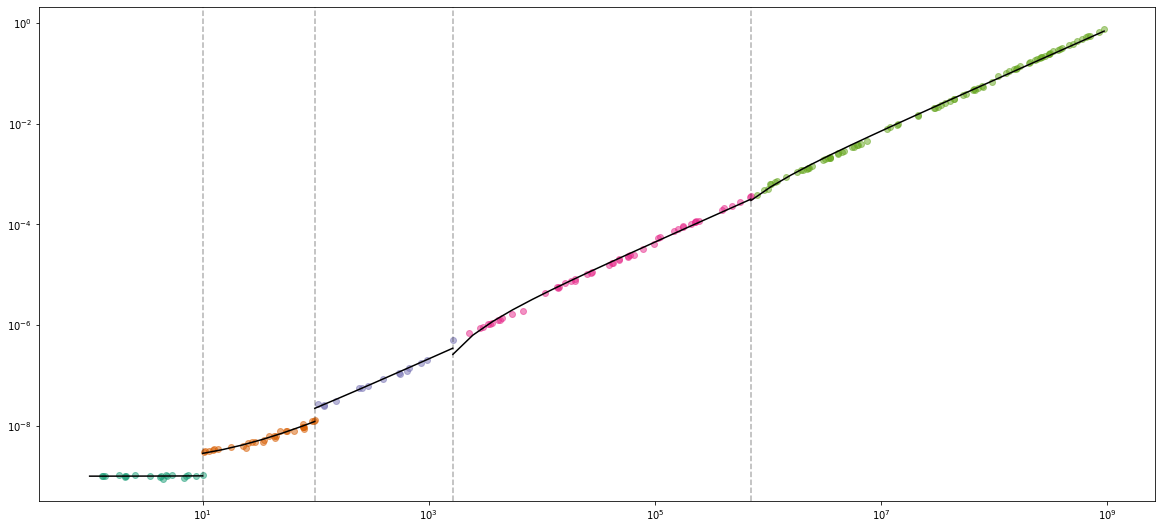

In [4]:
%%time
reg = compute_regression(x, y, mode='log')
print(len(reg.breakpoints))
print(reg)
reg.plot_dataset(log=True)

## Bottom-up

Here we remove breakpoints greedily, using the BIC.

In [5]:
%%time
reg.simplify()

CPU times: user 785 ms, sys: 3.91 ms, total: 789 ms
Wall time: 789 ms


,regression,RSS,BIC,AIC,BIClog,RSSlog,weighted_RSS,weighted_BIC,nb_breakpoints
0,"((1.2765492834188505, 1.0053901099618097e-09),...",0.000739,-2401.084318,-2463.752348,432.656899,1.659944,4.230258e-19,-9420.366197,4
1,"((1.2765492834188505, 1.0053901099618097e-09),...",0.000739,-2422.277587,-2471.752348,938.743809,4.296345,5.096075e-19,-9404.317947,3
2,"((1.2765492834188505, 1.0053901099618097e-09),...",0.000739,-2443.470857,-2479.752348,1438.182973,6.899507,7.464024e-19,-9349.186397,2
3,"((1.2765492834188505, 1.0053901099618097e-09),...",0.000823,-2443.196207,-2466.284428,2595.597762,12.792548,2.658461e-18,-9116.332130,1
4,"((1.2765492834188505, 1.0053901099618097e-09),...",0.000862,-2455.060274,-2464.955226,676658.170594,3383.211378,1.161538e-13,-7000.540850,0


/home/tom/Dropbox/Documents/Fac/phd/pycewise/pycewise/reg.py:562: RuntimeWarning: invalid value encountered in log
  A = numpy.log(y) - numpy.log(pred)


-inf < x ≤ 9.989e+00
	y ~ 1.510e-12x + 9.867e-10
9.989e+00 < x ≤ 9.808e+01
	y ~ 1.051e-10x + 1.752e-09
9.808e+01 < x ≤ 1.632e+03
	y ~ 2.105e-10x + 1.371e-09
1.632e+03 < x ≤ 7.058e+05
	y ~ 4.473e-10x + -4.713e-07
7.058e+05 < x ≤ inf
	y ~ 7.339e-10x + -2.221e-04
CPU times: user 973 ms, sys: 3.92 ms, total: 977 ms
Wall time: 967 ms


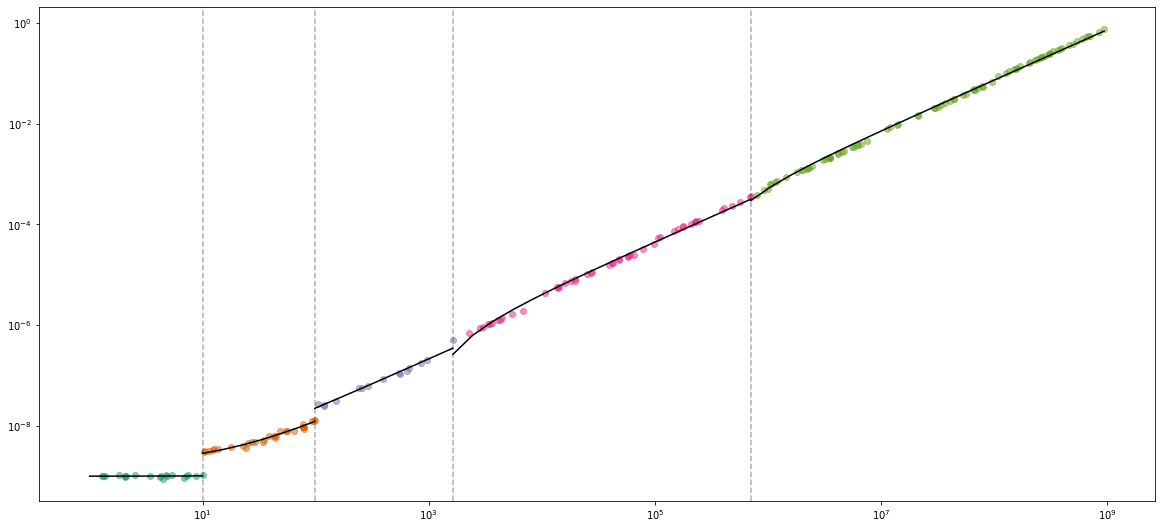

In [6]:
%%time
auto_simple = reg.auto_simplify()
print(auto_simple)
auto_simple.plot_dataset(log=True)

In [7]:
auto_simple.to_pandas()

,min_x,max_x,intercept,coefficient,RSS,MSE,RSSlog,weighted_RSS,statsmodels_intercept,statsmodels_coefficient
0,-inf,9.989428e+00,9.867392e-10,1.509865e-12,3.060349e-20,1.530174e-21,0.032580,2.149756e-21,9.867703e-10,1.674511e-12
1,9.989428e+00,9.808278e+01,1.752124e-09,1.050573e-10,8.060818e-18,2.686939e-19,0.173873,5.726630e-21,1.752056e-09,1.055065e-10
2,9.808278e+01,1.632188e+03,1.371451e-09,2.104662e-10,1.282547e-14,8.550315e-16,0.216032,1.273185e-20,-2.579333e-08,2.781311e-10
3,1.632188e+03,7.058069e+05,-4.712529e-07,4.473480e-10,4.557566e-10,9.115132e-12,0.596063,9.808864e-20,-2.861175e-06,5.096485e-10
4,7.058069e+05,inf,-2.221068e-04,7.339109e-10,7.388283e-04,8.692098e-06,0.641397,3.043289e-19,-1.805634e-03,8.012942e-10
